To start IPython local engines, open a terminal in Jupyter lab and run ```ipcluster start -n 4```

In [1]:
#import hpc05
#client = hpc05.Client(profile='pbs', timeout=60)
#print("Connected to hpc05")

from ipyparallel import Client
client = Client()
print("Connected to local engines")

Connected to local engines


In [2]:
client.ids

[0, 1, 2, 3]

In [3]:
dview = client[:]
dview.use_dill()
lview = client.load_balanced_view()
print('Connected to {} engines.'.format(len(dview)))

Connected to 4 engines.


In [4]:
# set the working directory of clusters to the same folder as this notebook. 
import os
wd='"'+os.getcwd()+'"'
%px import sys, os; os.chdir($wd); os.getcwd()# %px is a magic command for parallel clusters

Out[0:1]: '/home/bomin/Desktop/QPCsupercurrent'

Out[1:1]: '/home/bomin/Desktop/QPCsupercurrent'

Out[2:1]: '/home/bomin/Desktop/QPCsupercurrent'

Out[3:1]: '/home/bomin/Desktop/QPCsupercurrent'

In [5]:
# Related third party imports
import holoviews as hv
import kwant
import numpy as np
import pandas as pd

# Local imports
import funcs

%matplotlib inline
hv.notebook_extension()

# Creating some wires as example

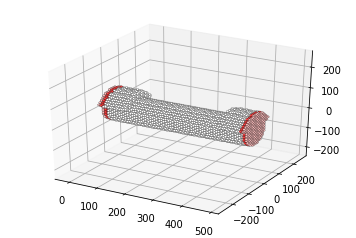

In [6]:
# Create system with infinite leads
syst_pars = dict(a=8, angle=0, site_disorder=False, holes=True, L=320, L_sc=80,
                 phi=135, r1=60, r2=90, shape='circle', with_leads=True,
                 with_shell=True, with_vlead=True)

syst, hopping = funcs.make_3d_wire(**syst_pars)
kwant.plot(syst);

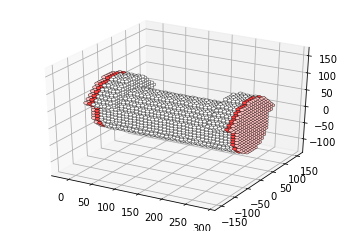

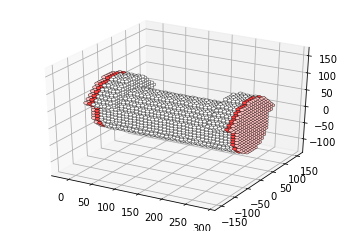

In [7]:
# Create system without leads and bigger SC regions
syst_pars['L_sc'] = 40
syst_pars['L'] = 200
syst, hopping = funcs.make_3d_wire(**syst_pars)
kwant.plot(syst)#, site_size=0, hop_lw=0.1);

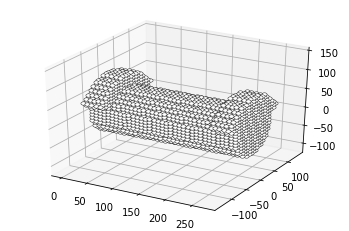

In [8]:
# Create system without leads
syst_pars['with_leads'] = False
syst, hopping = funcs.make_3d_wire(**syst_pars)
kwant.plot(syst);

# Mean free path calculation
See [mean-free-path.ipynb](mean-free-path.ipynb) for the data processing.

## Reduce all vals (Ls, salts, ...) to lenth 1 vectors to save time...

In [9]:
syst_pars = dict(a=8, angle=0, site_disorder=True, holes=False, L_sc=8,
                 phi=135, r1=60, r2=90, shape='circle', with_leads=True,
                 with_shell=False, with_vlead=False)

params = dict(alpha=20, B_x=0, B_y=0, B_z=0, Delta=0, g=50,
              orbital=True, V='lambda x: 0', **funcs.constants.__dict__)

Ls = [80]
salts = [0]
disorders = [0]
mus = [10]

vals = funcs.named_product(salt=salts, disorder=disorders, L=Ls, mu=mus)
print(len(vals))

def func(val, syst_pars=syst_pars, params=params):
    import kwant, funcs
    
    # Combine the fixed parameters `params` and the changing
    # parameters `val` to one dict and evaluate the string
    # lambda functions.
    params = funcs.parse_params(dict(**params, **val))
    
    # Remove the parameters from `params` that belong in `syst_pars`.
    for x in ['L']:
        syst_pars[x] = params.pop(x)

    syst, hopping = funcs.make_3d_wire(**syst_pars)
    smatrix = kwant.smatrix(syst, params=params)
    
    # Return a combined dictionary with the results and input.
    return dict(transmission=smatrix.transmission(0, 1),
                num_propagating=smatrix.num_propagating(0),
                **val)


1


In [ ]:
funcs.run_simulation(lview,func, vals, dict(**params, **syst_pars), fname, overwrite=True)

In [16]:
# using ralative path (path starts with "./")
fname = './tmp/I_c(B_x)_mu0_20meV_disorder0,75meV_T0.05K_orbital_SOI_Zeeman.hdf'

In [17]:
df = pd.read_hdf(fname)

In [18]:
df

,B_x,N_freqs,alpha,current_c,currents,disorder,g,mu,orbital,phase_c,...,phi,r1,r2,shape,site_disorder,t,with_leads,with_shell,with_vlead,git_hash
0,0,85,20,1.909058e-12,"[-1.4554850953961258e-17, -5.809932629547483e-...",0,50,0.0,True,2.491608,...,135,60,90,circle,True,2539.988077,True,True,True,84b612759dbfc0168d96b9b7d538523c4e15f991
1,0,43,20,1.976447e-09,"[0.0, -4.2488184687746676e-10, -8.301667658883...",0,50,2.0,True,1.589416,...,135,60,90,circle,True,2539.988077,True,True,True,84b612759dbfc0168d96b9b7d538523c4e15f991
2,0,7,20,1.351910e+01,"[-1.441232985342007e-10, -7.106489682718447, -...",0,50,4.0,True,2.365811,...,135,60,90,circle,True,2539.988077,True,True,True,84b612759dbfc0168d96b9b7d538523c4e15f991
3,0,9,20,1.673750e+01,"[-1.869317932823763e-10, -9.618053069900942, -...",0,50,6.0,True,2.426702,...,135,60,90,circle,True,2539.988077,True,True,True,84b612759dbfc0168d96b9b7d538523c4e15f991
4,0,9,20,1.748957e+01,"[1.0276237104250227e-10, -10.130754279877637, ...",0,50,8.0,True,2.415448,...,135,60,90,circle,True,2539.988077,True,True,True,84b612759dbfc0168d96b9b7d538523c4e15f991
5,0,10,20,8.482531e+01,"[1.407400525396543e-10, -67.91309636217441, -8...",0,50,10.0,True,2.640100,...,135,60,90,circle,True,2539.988077,True,True,True,84b612759dbfc0168d96b9b7d538523c4e15f991
6,0,12,20,9.869237e+01,"[8.166440430800888e-10, -83.94663117376471, -9...",0,50,12.0,True,2.645125,...,135,60,90,circle,True,2539.988077,True,True,True,84b612759dbfc0168d96b9b7d538523c4e15f991
7,0,13,20,1.037008e+02,"[7.230905844555616e-10, -89.96163835811498, -1...",0,50,14.0,True,2.696170,...,135,60,90,circle,True,2539.988077,True,True,True,84b612759dbfc0168d96b9b7d538523c4e15f991
8,0,13,20,1.072547e+02,"[-2.4070826480318043e-09, -93.33166846319041, ...",0,50,16.0,True,2.693459,...,135,60,90,circle,True,2539.988077,True,True,True,84b612759dbfc0168d96b9b7d538523c4e15f991
9,0,14,20,2.161628e+02,"[-1.084054614155645e-09, -193.2941659602993, -...",0,50,18.0,True,2.644352,...,135,60,90,circle,True,2539.988077,True,True,True,84b612759dbfc0168d96b9b7d538523c4e15f991


In [21]:
df.columns

Index(['transmission', 'num_propagating', 'salt', 'disorder', 'L', 'mu',
       'alpha', 'B_x', 'B_y', 'B_z', 'Delta', 'g', 'orbital', 'V', 'm_eff',
       'hbar', 'm_e', 'eV', 'e', 'meV', 'k', 'current_unit', 'mu_B', 't', 'c',
       'a', 'angle', 'site_disorder', 'holes', 'L_sc', 'phi', 'r1', 'r2',
       'shape', 'with_leads', 'with_shell', 'with_vlead', 'git_hash'],
      dtype='object')

# $B_x(I_c)$ combinations of effects and geometries:

In [18]:
syst_pars = dict(a=8, angle=0, site_disorder=False, holes=True, phi=135,
                 r1=60, r2=70, shape='circle', with_shell=True, with_vlead=True)

params = dict(B_y=0, B_z=0, Delta=60, c_tunnel=5/8, V=lambda x: 0, **funcs.constants.__dict__)

Ts = [0.1, 0.5, 1]
orbital_bools = [False, True]
gs = [0, 50]
alphas = [0, 20]
mus = [10, 15, 20, 25, 30]
Ls = [80, 160, 320, 640]
leads = [(True, 8), (False, 400)]
Bs = np.linspace(0, 2, 101)

vals = funcs.named_product(T=Ts, L=Ls, orbital=orbital_bools,
                           g=gs, alpha=alphas, mu=mus, leads=leads, B_x=Bs)

def func(val, syst_pars=syst_pars, params=params):
    import funcs
    val['with_leads'], val['L_sc'] = val['leads']

    # Combine the fixed parameters `params` and the changing
    # parameters `val` to one dict and evaluate the string
    # lambda functions.
    params = funcs.parse_params(dict(**params, **val))

    # Remove the parameters from `params` that belong in `syst_pars`.
    for x in ['with_leads', 'L_sc', 'L']:
        syst_pars[x] = params.pop(x)

    syst, hopping = funcs.make_3d_wire(**syst_pars)

    # Return a combined dictionary with the results and input.
    return dict(**funcs.I_c(syst, hopping, params), **val)

fname = "tmp/I_c(B_x)_no_disorder_combinations_of_effects_and_geometries_{}.hdf"
funcs.run_simulation(lview, func, vals, dict(**params, **syst_pars), fname, 2000)


NameError: name 'lview' is not defined

# $B_x(I_c)$ with disorder:
* Main paper figure 4
* Supplementary materials figure 8

In [13]:
ONLY_PAPER_COMBINATIONS = False

syst_pars = dict(a=8, angle=0, site_disorder=True, holes=True, L=320,
                 L_sc=8, phi=135, r1=60, r2=90, shape='circle',
                 with_leads=True, with_shell=True, with_vlead=True)

params = dict(B_y=0, B_z=0, Delta=60, c_tunnel=5/8, V='lambda x: 0', T=50e-3, **funcs.constants.__dict__)

#Bs = np.linspace(0, 0.5, 6)
Bs = [0]

if ONLY_PAPER_COMBINATIONS:
    # These are all the combinations of effects that are showed in Fig. 4 of the main paper.
    vals = [[(0, 0, True, 50, 20, 10, B),
             (0, 0, False, 50, 20, 10, B),
             (0, 0, True, 50, 0, 10, B),
             (0, 0, False, 50, 0, 10, B),
             (0, 0, True, 50, 20, 20, B),
             (0, 0, False, 50, 20, 20, B),
             (0, 0, True, 50, 0, 20, B),
             (0, 0, False, 50, 0, 20, B),
             (7, 75, True, 50, 20, 20, B)]
            for B in Bs]
    vals = sum(vals, [])
    names = ['salt', 'disorder', 'orbital', 'g', 'alphas', 'mu', 'B_x']
    vals = [dict(zip(names, val)) for val in vals]

else:
    # Calculate all combinations of effects (which is much slower.)
#    vals = funcs.named_product(salt=np.arange(0, 8, 1), disorder=[0, 75], 
#                               orbital=[False, True], g=[0, 50], alpha=[0, 20],
#                               mu=[10, 20], B_x=Bs)

    vals = funcs.named_product(salt=np.linspace(0, 8, 2), disorder=[0, 75], 
                               orbital=[True], g=[50], alpha=[20],
                               mu=np.linspace(0,20,11), B_x=Bs)
    # Filter out different salts when there is no disorder.
    vals = [val for val in vals if not (val['salt'] > 0 and val['disorder'] == 0)]

print(len(vals))

def func(val, syst_pars=syst_pars, params=params):
    import funcs
    syst, hopping = funcs.make_3d_wire(**syst_pars)
    
    # Combine the fixed parameters `params` and the changing
    # parameters `val` to one dict and evaluate the string
    # lambda functions.
    params = funcs.parse_params(dict(**params, **val))
    
    # Return a combined dictionary with the results and input.
    return dict(**funcs.I_c(syst, hopping, params), **val)

33


In [15]:
fname_i = "tmp/I_c(B_x)_mu0_20meV_disorder0,75meV_T0.05K_orbital_SOI_Zeeman.hdf"
funcs.run_simulation(lview, func, vals, dict(**params, **syst_pars), fname_i, 2500)

  33/33 tasks finished after 72890 s
done
Saved tmp/I_c(B_x)_mu0_20meV_disorder0,75meV_T0.05K_orbital_SOI_Zeeman.hdf, 0 more files to go, 0:00:00 time left before everything is done.


/home/bomin/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/generic.py:1299: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->['currents', 'phases', 'V', 'shape', 'git_hash']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


# Rotation of the magnetic field in the $xy$-plane
* Supplementary materials figure 10

![](https://upload.wikimedia.org/wikipedia/commons/thumb/4/4f/3D_Spherical.svg/200px-3D_Spherical.svg.png)

In [20]:
syst_pars = dict(a=8, angle=0, site_disorder=True, holes=True, L=160, L_sc=8,
                 phi=135, r1=50, r2=70, shape='circle',
                 with_leads=True, with_shell=True, with_vlead=True)

params = dict(alpha=20, B_z=0, Delta=60, g=50, mu=20, salt=7,
              orbital=True, c_tunnel=5/8, V='lambda x: 0', T=100e-3, **funcs.constants.__dict__)

Bs = np.linspace(0, 2, 101)
thetas = [0, 45, 90]
vals = funcs.named_product(B=Bs, theta=thetas, disorder=[0, 75])

def func(val, syst_pars=syst_pars, params=params):
    import funcs
    import numpy as np
    angle = np.deg2rad(val['theta'])
    val['B_x'] = val['B'] * np.cos(angle).round(15)
    val['B_y'] = val['B'] * np.sin(angle).round(15)
    
    # Combine the fixed parameters `params` and the changing
    # parameters `val` to one dict and evaluate the string
    # lambda functions.
    params = funcs.parse_params(dict(**params, **val))

    syst, hopping = funcs.make_3d_wire(**syst_pars)

    # Return a combined dictionary with the results and input.
    return dict(**funcs.I_c(syst, hopping, params), **val)

fname = 'data/I_c(B_x)_mu20meV_rotation_of_field_in_xy_plane.hdf'
funcs.run_simulation(lview, func, vals, dict(**syst_pars, **params), fname, None, overwrite=True)

NameError: name 'lview' is not defined

# Tuning the induced gap

In [21]:
syst_pars = dict(a=8, angle=0, site_disorder=False, holes=True,
                 L=80, L_sc=8, phi=135, r1=50, r2=70, shape='circle',
                 with_leads=True, with_shell=True, with_vlead=False)

params = dict(alpha=20, B_x=0, B_y=0, B_z=0, g=50, orbital=True,
              c_tunnel=5/8, V='lambda x: 0', **funcs.constants.__dict__,)

mus = np.linspace(2, 30, 50)
Deltas = np.linspace(0, 100, 50)

vals = funcs.named_product(Delta=Deltas, mu=mus)

def func(val, syst_pars=syst_pars, params=params):
    import funcs
    import numpy as np
    lead = funcs.make_3d_wire(**syst_pars)[0].leads[1]

    # Combine the fixed parameters `params` and the changing
    # parameters `val` to one dict and evaluate the string
    # lambda functions.
    params = funcs.parse_params(dict(**params, **val))

    # Create the Hamiltonian `ham` at k=0.
    h0 = lead.cell_hamiltonian(params=params)
    t0 = lead.inter_cell_hopping(params=params)
    ham = h0 + t0 + t0.conj().T

    # Find the energies.
    ev = np.linalg.eigvalsh(ham)
    
    # Return a combined dictionary with the results and input.
    return dict(E_min=np.abs(ev).min(), **val)

funcs.run_simulation(lview, func, vals, dict(**params, **syst_pars), 'data/gap_tuning.hdf')

NameError: name 'lview' is not defined

In [22]:
# Plot the gaps and find the `Delta` that is needed for the required `Delta_induced`.
df = pd.read_hdf('data/gap_tuning.hdf')
Deltas = sorted(df.Delta.unique())
mus = sorted(df.mu.unique())
gap = np.reshape(df.E_min.values, (len(Deltas), len(mus))) 
max_gap = np.max(np.min(gap, axis=1))
print("Max gap is {} meV".format(max_gap))

FileNotFoundError: File data/gap_tuning.hdf does not exist

In [23]:
hv.Curve((Deltas, gap.min(axis=1)), kdims=[r'$\Delta$'], vdims=[r'$E_{gap}$'],
         label=r"$E_{gap}$ over range of $\Delta$'s")

NameError: name 'gap' is not defined

In [24]:
Delta_ind = {delta: hv.Path((mus, evs), kdims=[r'$\mu$', ('E_gap', r'$E_{gap}$')]) 
      for evs, delta in zip(gap, Deltas)}

hm = hv.HoloMap(Delta_ind, kdims=[r'$\Delta$'])
(hm.select(E_gap=(0.15, 0.40)) * hv.HLine(0.25))

NameError: name 'gap' is not defined

## Gate simulation with and without disorder $I_c(B_x, V)$
* Main paper figure 5(b)
* Supplementary materials figure 9

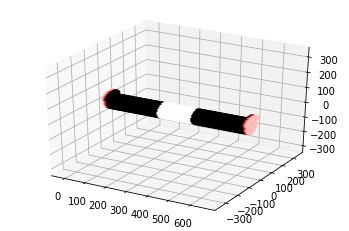

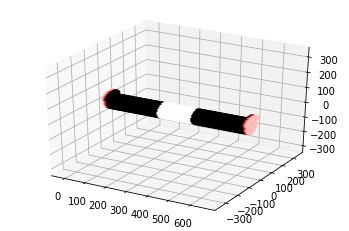

In [25]:
# Plot test
syst_pars = dict(a=8, angle=0, site_disorder=False, holes=True,
                 L=640, L_sc=8, phi=135, r1=50, r2=70, shape='circle',
                 with_leads=True, with_shell=True, with_vlead=True)

syst, hopping = funcs.make_3d_wire(**syst_pars)
gate_fun = funcs.gate(syst, 100, 160)
sites = [gate_fun(pos[0]) for pos in [i.pos for i in syst.sites]]
kwant.plot(syst, site_lw=0, site_color=sites, colorbar=False)

In [26]:
syst_pars = dict(a=8, angle=0, site_disorder=True, holes=True,
                 L=640, L_sc=8, phi=135, r1=50, r2=70, shape='circle',
                 with_leads=True, with_shell=True, with_vlead=True)

params = dict(alpha=20, B_y=0, B_z=0, Delta=60, g=50, mu=20, orbital=True,
              c_tunnel=5/8, salt=7, T=100e-3, **funcs.constants.__dict__)

Bs = np.linspace(0, 0.5, 51)
Vs = np.linspace(0, 10, 51)
gate_sizes = [160]
disorders = [0, 75]

vals = funcs.named_product(gate_size=gate_sizes,
                           disorder=disorders, V=Vs, B_x=Bs)

def func(val, syst_pars=syst_pars, params=params):
    import funcs
    syst, hopping = funcs.make_3d_wire(**syst_pars)

    # Combine the fixed parameters `params` and the changing
    # parameters `val` to one dict and evaluate the string
    # lambda functions.
    params = funcs.parse_params(dict(**params, **val))

    # Create a potential function for the gate.
    params['V'] = funcs.gate(syst, params['V'], params['gate_size'])

    # Return a combined dictionary with the results and input.
    return dict(**funcs.I_c(syst, hopping, params), **val)

fname = "tmp/I_c(B_x,_V)_gate160nm_mu20meV_disorder0,75meV_T0.1K_{}.hdf"
funcs.run_simulation(lview, func, vals, dict(**params, **syst_pars), fname, 2500)

NameError: name 'lview' is not defined

# 1D toymodel $I_c(\alpha, B_x)$
Supplementary materials figure 7

In [27]:
syst_pars = dict(a=10, L=500, L_sc=100)

params = dict(B_y=0, B_z=0, Delta=0.25, g=50, V='lambda x: 0', T=0.1,
              **funcs.constants.__dict__)

alphas = np.linspace(0, 30, 101)
B_xs = np.linspace(0, 1.4, 101)
mus = [0.1, 0.3, 1, 3, 10, 30]

vals = funcs.named_product(alpha=alphas, B_x=B_xs, mu=mus)

def func(val, syst_pars=syst_pars, params=params):
    import funcs
    syst, hopping = funcs.make_1d_wire(**syst_pars)

    # Combine the fixed parameters `params` and the changing
    # parameters `val` to one dict and evaluate the string
    # lambda functions.
    params = funcs.parse_params(dict(**params, **val))

    # Return a combined dictionary with the results and input.
    return dict(**funcs.I_c(syst, hopping, params), **val)

funcs.run_simulation(lview, func, vals, dict(**params, **syst_pars),
                     'tmp/1d_alpha_vs_B_x_{}.hdf', N=20000, overwrite=True)

NameError: name 'lview' is not defined